In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import adhtools.utils

In [3]:
from lxml import etree
from tqdm import tqdm

def stemmer_xml2df2(fname):
    result = []
    
    # Extract the words
    context = etree.iterparse(fname, events=('end', ), tag=('word'))
    for event, elem in context:
        stem = None
        for a in elem.getchildren():
            if a.tag == 'analysis':
                stem = a.attrib['stem']
        result.append({'word': elem.attrib['value'], 'proposed_root': stem})
        
        # make iteration over context fast and consume less memory
        #https://www.ibm.com/developerworks/xml/library/x-hiperfparse
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    
    return pd.DataFrame(result)

def analyzer_xml2df2(fname):
    result = []
    
    # Extract the words
    context = etree.iterparse(fname, events=('end', ), tag=('word'))
    for event, elem in context:
        word = elem.attrib['value']
        #print(repr(word))
        if word != '':
            roots = []
            for a in elem.getchildren():
                if a.tag == 'analysis':
                    try:
                        roots.append(a.attrib['root'])
                    except:
                        pass
            roots = list(set(roots))
            if len(roots) == 0:
                roots.append('NOANALYSIS')
            result.append({'word': elem.attrib['value'], 'proposed_root': '\\'.join(roots)})
        
        # make iteration over context fast and consume less memory
        #https://www.ibm.com/developerworks/xml/library/x-hiperfparse
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    
    return pd.DataFrame(result)

In [4]:
def read_file_analyzer(in_file):
    data = analyzer_xml2df2(in_file)
    return(list(data['word']))

def read_file_stemmer(in_file):
    data = stemmer_xml2df2(in_file)
    return(list(data['proposed_root']))

def corpus(in_files, analyzer=True):

    for in_file in in_files:
        if analyzer:
            ws = read_file_analyzer(in_file)
        else:
            ws = read_file_stemmer(in_file)
        
        yield(ws)

In [4]:
# maak term/document matrix van 1 boek uit Fiqh met document per chapter

import glob

#book_files = glob.glob('/home/jvdzwaan/data/tmp/adh/2018-10-23-Fiqh-stemmed-chapters/*.xml')
book_files = glob.glob('/media/sf_VBox_Shared/Arabic/Fiqh/2018-11-13-Fiqh-stemmed-chapters/*.xml')
book_files.sort()
print(len(book_files))
print(book_files[0])

10066
/media/sf_VBox_Shared/Arabic/Fiqh/2018-11-13-Fiqh-stemmed-chapters/0179MalikIbnAnas.Muwatta-00000.xml


In [28]:
%%time
data = adhtools.utils.corpus_str(book_files, analyzer=False)
#data = [' '.join(list(terms)) for terms in c]

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs


In [29]:
%%time
from sklearn.feature_extraction.text import CountVectorizer

def split(string):
    return string.split()

count_vect = CountVectorizer(input='content', lowercase=False, tokenizer=split)
word_counts = count_vect.fit_transform(data)

CPU times: user 16min 17s, sys: 38 s, total: 16min 55s
Wall time: 18min 26s


In [30]:
word_counts.shape

(10066, 71036)

In [31]:
count_vect.vocabulary_.get(u'غرب')

23446

In [32]:
%%time
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf = tfidf_transformer.fit_transform(word_counts)
print(tfidf.shape)

(10066, 71036)
CPU times: user 1.68 s, sys: 36 ms, total: 1.72 s
Wall time: 924 ms


In [33]:
%%time
from sklearn.metrics.pairwise import cosine_similarity

result = cosine_similarity(tfidf, tfidf)

CPU times: user 34.4 s, sys: 1.08 s, total: 35.5 s
Wall time: 35 s


In [34]:
result.shape

(10066, 10066)

In [21]:
chapter_names = [os.path.basename(f) for f in book_files]
sim_df = pd.DataFrame(result, columns=chapter_names, index=chapter_names)

In [ ]:
sim_df.to_csv('/media/sf_VBox_Shared/Arabic/Analyses/chapter_similarity/fiqh-chapters-similarities.csv')

In [14]:
%%time

# cluster chapters based on affinity propagation
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation().fit(result)

CPU times: user 6min 45s, sys: 41.6 s, total: 7min 27s
Wall time: 3min 11s


In [15]:
from sklearn import metrics

cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

Estimated number of clusters: 281


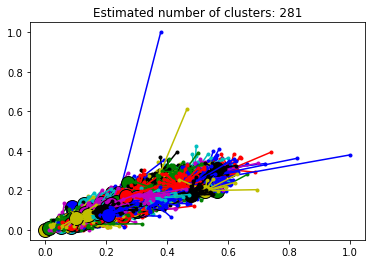

In [16]:
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = result[cluster_centers_indices[k]]
    plt.plot(result[class_members, 0], result[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for c in result[class_members]:
        plt.plot([cluster_center[0], c[0]], [cluster_center[1], c[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
import os

from sklearn.metrics.pairwise import linear_kernel

def find_similar(tfidf_matrix, index, top_n = 5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    return [(index, cosine_similarities[index]) for index in related_docs_indices][0:top_n]

def find_similar_threshold(tfidf_matrix, index, threshold=0.5):
    cosine_similarities = linear_kernel(tfidf_matrix[index:index+1], tfidf_matrix).flatten()
    related_docs_indices = [i for i in cosine_similarities.argsort()[::-1] if i != index]
    res = []
    for index in related_docs_indices:
        sim = cosine_similarities[index]
        if sim > threshold:
            res.append((index, sim))
    return res

for idx, sim in find_similar(x, 1, top_n=20):
    print(sim, os.path.basename(book_files[idx]))

In [ ]:
for idx, sim in find_similar_threshold(x, 1):
    print(sim, idx)

In [18]:
book_files[8001]

'/media/sf_VBox_Shared/Arabic/Fiqh/2018-11-13-Fiqh-stemmed-chapters/1091MuhammadMuhsinFaydKashani.MafatihSaraiC-00543.xml'

In [25]:
x.shape

(10066,)

In [35]:
%%time
from sklearn.metrics.pairwise import cosine_distances

from sklearn.manifold import TSNE

dist = cosine_distances(tfidf, tfidf)

X_embedded = TSNE(n_components=2, metric='precomputed').fit_transform(dist)
print(X_embedded.shape)

(10066, 2)
CPU times: user 9min 9s, sys: 11.9 s, total: 9min 21s
Wall time: 3min 46s


In [36]:
X_embedded[:,0]

array([ 8.234939 ,  8.133355 ,  7.0359383, ..., -1.6819388, -2.1199534,
       -2.1478717], dtype=float32)

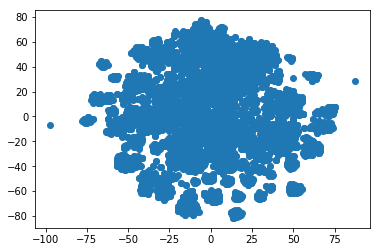

In [37]:
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.show()

In [41]:
from tqdm import tqdm
from lxml import etree

# read the metadata
def read_metadata(in_files):
    result = []
    
    for fname in tqdm(in_files, total=len(in_files)):
    
        data = {}
        # Extract the words
        context = etree.iterparse(fname, events=('end', ), tag=('meta'))
        for event, elem in context:
            name = elem.attrib['name']
            value = elem.text
        
            data[name] = value
        
            # make iteration over context fast and consume less memory
            #https://www.ibm.com/developerworks/xml/library/x-hiperfparse
            elem.clear()
            while elem.getprevious() is not None:
                del elem.getparent()[0]
        result.append(data)
    
    return pd.DataFrame(result)

md = read_metadata(book_files)
md.head()

100%|██████████| 10066/10066 [14:48<00:00, 11.32it/s]


,All_tokens_per-century,AuthorAKA,AuthorBORNC,AuthorBORNH,AuthorDIEDC,AuthorDIEDH,AuthorNAME,Author_Geographical_Area,BookSUBJ,BookTITLE,BookURI,BookVOLS,Century,ChapterTitle,Number_of_tokens,Tagging,VolumeTitle
0,nan,مالك,711,93,795,179,مالك بن أنس بن مالك بن عامر الأصبحي المدني,Fertile Crescent,مالكي,موطأ الإمام مالك,0179MalikIbnAnas.Muwatta,1,2ndH/8thC and 3rdH/9thC century,باب وقوت الصلاة,151424,Books ### | Chapters ### || Quran @QB@ @QE@,كتاب وقوت الصلاة
1,nan,مالك,711,93,795,179,مالك بن أنس بن مالك بن عامر الأصبحي المدني,Fertile Crescent,مالكي,موطأ الإمام مالك,0179MalikIbnAnas.Muwatta,1,2ndH/8thC and 3rdH/9thC century,باب وقت الجمعة,151424,Books ### | Chapters ### || Quran @QB@ @QE@,كتاب وقوت الصلاة
2,nan,مالك,711,93,795,179,مالك بن أنس بن مالك بن عامر الأصبحي المدني,Fertile Crescent,مالكي,موطأ الإمام مالك,0179MalikIbnAnas.Muwatta,1,2ndH/8thC and 3rdH/9thC century,باب من,151424,Books ### | Chapters ### || Quran @QB@ @QE@,كتاب وقوت الصلاة
3,nan,مالك,711,93,795,179,مالك بن أنس بن مالك بن عامر الأصبحي المدني,Fertile Crescent,مالكي,موطأ الإمام مالك,0179MalikIbnAnas.Muwatta,1,2ndH/8thC and 3rdH/9thC century,باب ما جاء في دلوك الشمس وغسق الليل حدثني يحيى عن,151424,Books ### | Chapters ### || Quran @QB@ @QE@,كتاب وقوت الصلاة
4,nan,مالك,711,93,795,179,مالك بن أنس بن مالك بن عامر الأصبحي المدني,Fertile Crescent,مالكي,موطأ الإمام مالك,0179MalikIbnAnas.Muwatta,1,2ndH/8thC and 3rdH/9thC century,باب النوم عن الصلاة,151424,Books ### | Chapters ### || Quran @QB@ @QE@,كتاب وقوت الصلاة


In [43]:
md.shape

(10066, 17)

In [45]:
md['filename'] = chapter_names

In [ ]:
import numpy as np
import pandas as pd
import holoviews as hv
hv.extension('bokeh', 'matplotlib')

In [46]:
md.columns

Index(['All_tokens_per-century', 'AuthorAKA', 'AuthorBORNC', 'AuthorBORNH',
       'AuthorDIEDC', 'AuthorDIEDH', 'AuthorNAME', 'Author_Geographical_Area',
       'BookSUBJ', 'BookTITLE', 'BookURI', 'BookVOLS', 'Century',
       'ChapterTitle', 'Number_of_tokens', 'Tagging', 'VolumeTitle',
       'filename'],
      dtype='object')

In [53]:
data = md.copy()
data['x'] = X_embedded[:,0]
data['y'] = X_embedded[:,1]

In [54]:
data = data[['x', 'y', 'BookSUBJ', 'BookTITLE', 'VolumeTitle', 'ChapterTitle', 'Century', 'filename', 'BookURI']]
data.head()

,x,y,BookSUBJ,BookTITLE,VolumeTitle,ChapterTitle,Century,filename,BookURI
0,8.234939,45.991196,مالكي,موطأ الإمام مالك,كتاب وقوت الصلاة,باب وقوت الصلاة,2ndH/8thC and 3rdH/9thC century,0179MalikIbnAnas.Muwatta-00000.xml,0179MalikIbnAnas.Muwatta
1,8.133355,45.129589,مالكي,موطأ الإمام مالك,كتاب وقوت الصلاة,باب وقت الجمعة,2ndH/8thC and 3rdH/9thC century,0179MalikIbnAnas.Muwatta-00001.xml,0179MalikIbnAnas.Muwatta
2,7.035938,57.224480,مالكي,موطأ الإمام مالك,كتاب وقوت الصلاة,باب من,2ndH/8thC and 3rdH/9thC century,0179MalikIbnAnas.Muwatta-00002.xml,0179MalikIbnAnas.Muwatta
3,7.538788,47.001827,مالكي,موطأ الإمام مالك,كتاب وقوت الصلاة,باب ما جاء في دلوك الشمس وغسق الليل حدثني يحيى عن,2ndH/8thC and 3rdH/9thC century,0179MalikIbnAnas.Muwatta-00003.xml,0179MalikIbnAnas.Muwatta
4,16.849596,42.098083,مالكي,موطأ الإمام مالك,كتاب وقوت الصلاة,باب النوم عن الصلاة,2ndH/8thC and 3rdH/9thC century,0179MalikIbnAnas.Muwatta-00004.xml,0179MalikIbnAnas.Muwatta


In [55]:
data.to_csv('/media/sf_VBox_Shared/Arabic/Analyses/chapter_similarity/2018-12-21-fiqh-chapter-similarity.csv', index=False)

In [ ]:
%%opts Scatter [tools=['hover'], height=800 width=800, color_index='BookSUBJ']
hv.Scatter(data)

In [ ]:
sc = hv.Scatter(data)
sc.options(color_index='BookSUBJ', cmap='Category10', height=700, width=700, tools=['hover'])

In [ ]:
sc = hv.Scatter(data)
sc.options(color_index='Century', cmap='Category10', height=700, width=700, tools=['hover'])

In [ ]:
renderer = hv.renderer('bokeh')
renderer.save(sc, 'fiqh-chapter-similarity-per-century')

In [ ]:
data.groupby('ChapterTitle').count().sort_values('x', ascending=False)